In [215]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler, LabelEncoder

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [216]:
column_names = ['PacketCounter', 'Acc_X', 'Acc_Y', 'Acc_Z']

df = pd.read_csv('acc_data (right_wrist).csv')
#df['Acc_Z'] = df['Acc_Z'].astype(np.float64)

In [217]:
df.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,Unnamed: 11
0,0,0.000000,0.000000,0.000000,
1,1,-8.874124,-0.679627,2.768368,
2,2,-8.873473,-0.613973,2.761706,
3,3,-8.834931,-0.518206,2.797576,
4,4,-8.921975,-0.508252,2.836315,


In [218]:
df.shape

(403, 5)

In [219]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

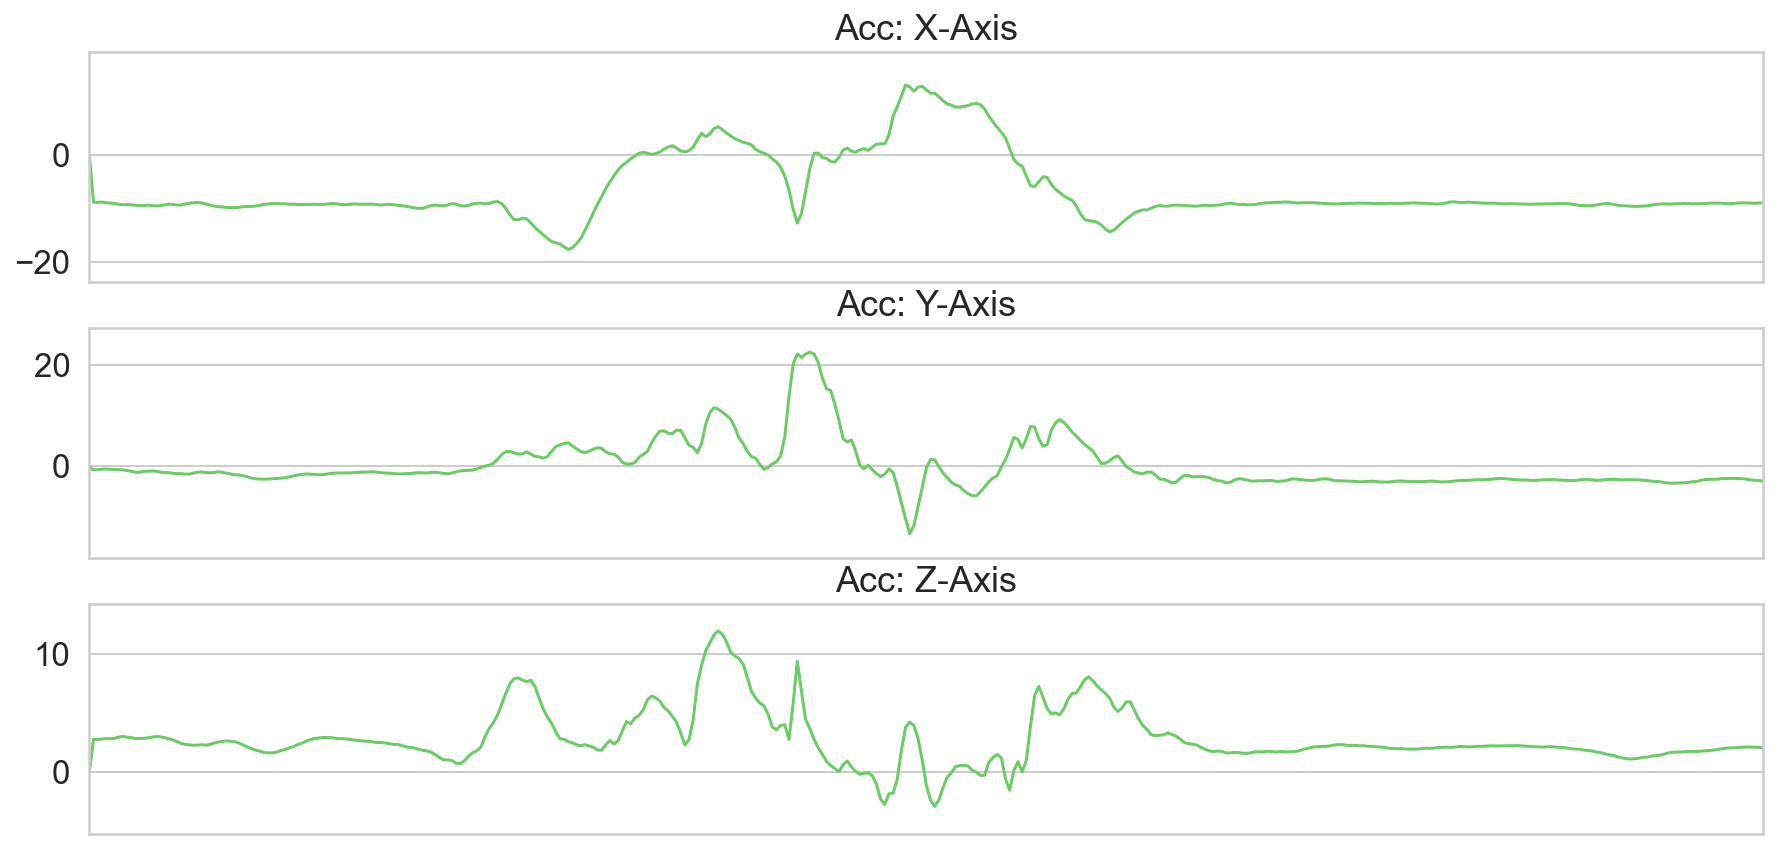

In [220]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis(ax0, df['PacketCounter'], df['Acc_X'], 'Acc: X-Axis')
plot_axis(ax1, df['PacketCounter'], df['Acc_Y'], 'Acc: Y-Axis')
plot_axis(ax2, df['PacketCounter'], df['Acc_Z'], 'Acc: Z-Axis')
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(top=0.90)
plt.show()

In [221]:
label = LabelEncoder()
df['label'] = label.fit_transform(df['PacketCounter'])
df.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,Unnamed: 11,label
0,0,0.000000,0.000000,0.000000,,0
1,1,-8.874124,-0.679627,2.768368,,1
2,2,-8.873473,-0.613973,2.761706,,2
3,3,-8.834931,-0.518206,2.797576,,3
4,4,-8.921975,-0.508252,2.836315,,4


In [222]:
X = df[['Acc_X', 'Acc_Y', 'Acc_Z']]
y = df['label']

In [223]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['Acc_X', 'Acc_Y', 'Acc_Z'])
scaled_X['label'] = y.values

scaled_X.head()

,Acc_X,Acc_Y,Acc_Z,label
0,1.065724,-0.010709,-1.222835,0
1,-0.378791,-0.153964,-0.015481,1
2,-0.378685,-0.140125,-0.018386,2
3,-0.372411,-0.119939,-0.002742,3
4,-0.386580,-0.117841,0.014152,4


In [232]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = scaled_X.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 100

X_train, y_train = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

In [233]:
print(X_train.shape, y_train.shape)

(303, 100, 3) (1212, 1)


In [228]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [206]:
print(X_train.shape, y_train.shape)


(0,) (0, 1)


In [207]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

IndexError: tuple index out of range

In [208]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.